In [ ]:
pip install faker


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.9 MB/s eta 0:00:00


# MOCK VERİ ÜRETİMİ

In [ ]:
import pandas as pd
import numpy as np
from faker import Faker
import random
from datetime import datetime, timedelta

# Sabit değerler
MFA_METHODS = ['SMS', 'OTP', 'Mail', 'None']
APPLICATIONS = ['CRM', 'HR System', 'ERP']
BROWSERS = ['Chrome', 'Firefox', 'Safari', 'Edge', 'Brave']
OS_LIST = ['Windows 10', 'macOS', 'Linux', 'Kali Linux', 'Windows 11']
UNITS = ['Bilgi İşlem', 'Satış', 'Pazarlama', 'Finans', 'Yönetim', 'İK', 'Muhasebeci']
TITLES = ['Takım Lideri', 'Uzman', 'Yönetici', 'Stajyer', 'Asistan', 'Direktör']


ANOMALY_RATE= 0.09

fake = Faker('tr_TR')

# Burada Her personlin sisteme giriş yapmadan önce alışkanlıkları alınıyor.
# Bu alışkanlıklara göre değişen bir durumda risk analizi işlemi yapılacaktır.
personels = {}
# Personel Üretme Fonksiyonu
def generate_personels(num_users=100):
    """Personel Listesi Oluşturur"""

    for i in range(num_users):
        personel_id = f"U{10000 + i}"
        personels[personel_id] = {
            "CreatedAt":"2024-01-01 09:00:00", # Default olarak
            "ClientIP": "192.168.1.15",# Default olarak atanan ID
            "operation_system":random.choice([o for o in OS_LIST if o !="Kali Linux"]),
            "browser": random.choice(BROWSERS),
            "application": random.choice(APPLICATIONS),
            "mfa_method":random.choice([m for m in MFA_METHODS if m != "None"]), # mfa 3 seçenekten herhangi birini alabilecek ancak none olarak bir alışkanlık kaydedilmeyecektir.
            "unit": random.choice(UNITS),
            "title": random.choice(TITLES),
        }
    return personels



IP Adresini %10 rassalıkta üret

In [ ]:
def generate_ip(is_anamoly):
    """IP adresi üretir - %10 oranında olağandışı IP"""
    if is_anamoly and random.random() < 0.4:  # %10 oranında olağandışı IP
        return  fake.ipv4_public()
    else:  # %90 oranında normal şirket IP'si (192.168.x.x)
        return f"192.168.{random.randint(0, 255)}.{random.randint(0, 255)}"

Giriş Saatini Üret

In [ ]:
def is_work_hours_vectorized(date_series):
    """Mesai saatleri kontrolü - Vektörize edilmiş versiyon"""
    # String series'i datetime'a çevir
    dt_series = pd.to_datetime(date_series)

    # Hafta içi kontrolü (Pazartesi=0, Pazar=6)
    is_weekday = dt_series.dt.weekday < 5

    # Saat kontrolü (9:00-17:30)
    hour = dt_series.dt.hour
    minute = dt_series.dt.minute

    # 9:00'dan büyük veya eşit ve 17:30'dan küçük veya eşit
    is_work_time = (hour > 9) | ((hour == 9) & (minute >= 0)) & \
                   (hour < 17) | ((hour == 17) & (minute <= 30))

    return is_weekday & is_work_time

def is_work_hours(date_str):
    """Mesai saatleri kontrolü: Hafta içi ve 09:00-17:30 arası"""
    dt = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')

    if dt.weekday() >= 5:
        return False  # Cumartesi veya Pazar

    work_start = dt.replace(hour=9, minute=0, second=0, microsecond=0)
    work_end = dt.replace(hour=17, minute=30, second=0, microsecond=0)

    return work_start <= dt <= work_end

def generate_datetime(is_anomaly, personel_info):
    """Tarih üretir - anomaly durumunda mesai saatleri dışında olabilir"""
    base_date = datetime.now() - timedelta(days=random.randint(1, 365))

    if is_anomaly and random.random() < 0.3:
        # Mesai saatleri dışı (18:00-08:00 arası veya hafta sonu)
        if random.random() < 0.5:
            # Gece saatleri
            hour = random.choice(list(range(0, 8)) + list(range(19, 24)))
        else:
            # Hafta sonu
            base_date = base_date + timedelta(days=random.choice([5, 6]))  # Cumartesi veya Pazar
            hour = random.randint(0, 23)
    else:
        # Normal mesai saatleri (08:00-18:00, Pazartesi-Cuma)
        hour = random.randint(8, 17)
        # Hafta içi günlere ayarla
        while base_date.weekday() >= 5:  # 5=Cumartesi, 6=Pazar
            base_date = base_date + timedelta(days=1)

    return base_date.replace(
        hour=hour,
        minute=random.randint(0, 59),
        second=random.randint(0, 59),
        microsecond=0
    )

Mock Verisi Üret

In [ ]:
def generate_mock_data():
    """Ana veri üretici fonksiyonu"""
    print("Mock veri üretimi başlıyor...")

    # Kullanıcıları oluştur
    personels = generate_personels(100)

    # Veri listesi
    data = []

    total_records = 0
    anomaly_count = 0

    for personel_id, personel_info in personels.items():
        # Her kullanıcı için ortalama 1000 giriş (900-1100 arası rastgele)
        num_logins = random.randint(900, 1100)



        for _ in range(num_logins):

            #anomaly olacak mı olmayacak mı
            is_anamoly= random.random() < ANOMALY_RATE
            # Rassal tarih oluştur.
            created_at = generate_datetime(is_anamoly,personel_info)

            mfa_method= personel_info["mfa_method"]
            browser=personel_info["browser"]
            application=personel_info["application"]
            operation_system=personel_info["operation_system"]

            # Application için rassal değişim
            if is_anamoly:
              anomaly_count += 1
              if random.random()< 0.1:
                application = random.choice(APPLICATIONS)
                # Browser için rassal değişim
              if random.random() <0.1:
                browser = random.choice(BROWSERS)
                # OS için rassal değişim
              if random.random()< 0.1:
                operation_system = random.choice(OS_LIST)
                # MFA için rassal değişim
              if random.random()< 0.1:
                mfa_method = random.choice([m for m in MFA_METHODS if m != personel_info["mfa_method"]])

            record = {
                "personel_ID":personel_id,
                'MFAMethod':mfa_method,
                'CreatedAt': created_at.strftime('%Y-%m-%d %H:%M:%S'),
                'ClientIP': generate_ip(is_anamoly),  # anomly varsa eğer ip adresi ona göre değişiyor
                'Application': application,
                'Browser': browser,
                'OS': operation_system,
                'Unit': personel_info['unit'],
                'Title': personel_info['title'],
                "is_anamoly": int(is_anamoly)
            }

            data.append(record)
            total_records += 1

    # DataFrame oluştur
    df = pd.DataFrame(data)

    # Tarihe göre sırala
    df = df.sort_values(by=['personel_ID', 'CreatedAt'], ascending=[True, True]).reset_index(drop=True)

    print(f"Toplam kayıt sayısı: {total_records:,}")
    print(f"Toplam kullanıcı sayısı: {len(personels)}")
    print(f"Kullanıcı başına ortalama giriş: {total_records/len(personels):.1f}")
    print(f"Anomali kayıt sayısı: {anomaly_count:,} (%{(anomaly_count/total_records)*100:.1f})")

    return df

MOCK VERİ ÜRET

In [ ]:
df=generate_mock_data()

Mock veri üretimi başlıyor...
Toplam kayıt sayısı: 99,164
Toplam kullanıcı sayısı: 100
Kullanıcı başına ortalama giriş: 991.6
Anomali kayıt sayısı: 8,969 (%9.0)


In [ ]:
df.to_csv("mock_data.csv", index=False, encoding='utf-8')

In [ ]:
df.head(50)

,personel_ID,MFAMethod,CreatedAt,ClientIP,Application,Browser,OS,Unit,Title,is_anamoly
0,U10000,OTP,2024-06-10 10:28:20,192.168.224.122,CRM,Safari,macOS,İK,Asistan,0
1,U10000,OTP,2024-06-10 10:46:18,192.168.68.208,CRM,Safari,macOS,İK,Asistan,0
2,U10000,OTP,2024-06-10 11:21:02,192.168.82.113,CRM,Safari,macOS,İK,Asistan,0
3,U10000,OTP,2024-06-10 11:58:37,192.168.13.244,CRM,Safari,macOS,İK,Asistan,0
4,U10000,OTP,2024-06-10 14:09:40,192.168.143.163,CRM,Safari,macOS,İK,Asistan,0
5,U10000,OTP,2024-06-10 16:30:01,192.168.3.230,CRM,Safari,macOS,İK,Asistan,0
6,U10000,OTP,2024-06-11 11:34:38,192.168.74.63,CRM,Safari,macOS,İK,Asistan,0
7,U10000,OTP,2024-06-12 09:28:04,192.168.241.15,CRM,Safari,macOS,İK,Asistan,0
8,U10000,OTP,2024-06-12 09:31:22,192.168.232.196,CRM,Safari,macOS,İK,Asistan,0
9,U10000,OTP,2024-06-12 10:08:23,192.168.87.16,CRM,Safari,macOS,İK,Asistan,0


# Features'lara Belirli Ağırlıkların Verilmesi ile Risklerin Hesaplanması (Etiketlenmesi)

RİSK AĞIRLIKLARI

In [ ]:
# Risk ağırlıkları (risk faktörleri için negatif değerler)
RISK_WEIGHTS = {
    'ip_change': 0.30,       # Risk faktörü: skoru düşürür
    'mfa_is_none': 0.20,     # Risk faktörü: skoru düşürür
    'out_of_hours': 0.15,    # Risk faktörü: skoru düşürür
    'OS_change_kali_linux': 0.10,  # Risk faktörü: skoru düşürür
    'mfa_change': 0.10,      # Risk faktörü: skoru düşürür
    'OS_change': 0.05,       # Risk faktörü: skoru düşürür
    'browser_change': 0.05,  # Risk faktörü: skoru düşürür
    'is_intern': 0.05        # Risk faktörü: skoru düşürür
}

# Risk seviye eşikleri (100 üzerinden, düşük skor = yüksek risk)
RISK_THRESHOLDS = {
    'high': 30,      # 0-30: Yüksek risk
    'medium': 50,    # 30-50: Orta risk
    'low': 70,       # 50-70: Düşük risk
    'normal': 100    # 70-100: Normal (güvenli)
}

In [ ]:

def calculate_risk_features_vectorized(df):
    """Tüm DataFrame için risk özelliklerini vektörize edilmiş şekilde hesaplar"""
    print("Risk özellikleri hesaplanıyor...")

    # Personel profilleri için mapping dict'leri oluştur
    user_profiles = pd.DataFrame.from_dict(personels, orient='index').reset_index()
    user_profiles.columns = ['personel_ID'] + list(user_profiles.columns[1:])

    # Kolon isimlerini açık bir şekilde yeniden adlandır
    user_profiles = user_profiles.rename(columns={
        'operation_system': 'profile_operation_system',
        'browser': 'profile_browser',
        'application': 'profile_application',
        'mfa_method': 'profile_mfa_method',
        'unit': 'profile_unit',
        'title': 'profile_title'

    })

    # Ana DataFrame ile personel profillerini birleştir
    df_with_profiles = df.merge(user_profiles, on='personel_ID', how='left')

    # Risk feature'larını hesapla
    features_dict = {}
    print("BAslıyoor ...")
    # 1. IP Change
    features_dict['ip_change'] = (~df['ClientIP'].str.startswith('192.168')).astype(int)

    # 2. MFA Change
    features_dict['mfa_change'] = (df_with_profiles['MFAMethod'] != df_with_profiles['profile_mfa_method']).astype(int)

    # 3. MFA is None
    features_dict['mfa_is_none'] = (df_with_profiles['MFAMethod'] == 'None').astype(int)

    # 4. OS Change to Kali Linux
    features_dict['OS_change_kali_linux'] = (
        (df_with_profiles['profile_operation_system'] != 'Kali Linux') &
        (df_with_profiles['OS'] == 'Kali Linux')
    ).astype(int)

    # 5. OS Change
    features_dict['OS_change'] = (df_with_profiles['OS'] != df_with_profiles['profile_operation_system']).astype(int)
    print("saat  özellikleri hesaplanıyor...")

    # 6. Out of Hours
    features_dict['out_of_hours'] = (~is_work_hours_vectorized(df['CreatedAt'])).astype(int)

    # 7. Browser Change
    features_dict['browser_change'] = (df_with_profiles['Browser'] != df_with_profiles['profile_browser']).astype(int)

    # 8. Is Intern
    features_dict['is_intern'] = (df_with_profiles['Title'].str.lower() == 'stajyer').astype(int)


    # 9. Anomaly Count
    risk_factors = ['ip_change', 'mfa_change', 'mfa_is_none', 'OS_change_kali_linux', 'out_of_hours', 'browser_change']
    features_dict['anomaly_count'] = sum([features_dict[factor] for factor in risk_factors])

    print(f"Risk özellikleri hesaplandı. Toplam özellik sayısı: {len(features_dict)}")
    return pd.DataFrame(features_dict)

In [ ]:
def calculate_risk_score_vectorized(features_df):
    """Vektörize edilmiş risk skoru hesaplama (100 üzerinden)"""
    print("Risk skorları hesaplanıyor...")

    # Ana risk faktörleri
    main_factors = ['ip_change', 'mfa_change', 'mfa_is_none', 'OS_change_kali_linux',
                   'OS_change', 'out_of_hours', 'browser_change', 'is_intern']

    # Risk skorunu 1.0 ile başlat (maksimum güvenlik)
    risk_scores = np.full(len(features_df), 1.0)

    # Her risk faktörü için skoru düşür
    for factor in main_factors:
        if factor in features_df.columns and factor in RISK_WEIGHTS:
            # Risk faktörü varsa skoru düşür (çıkarma işlemi)
            risk_scores -= features_df[factor].values * abs(RISK_WEIGHTS[factor])

    # Minimum 0 ile sınırla (negatif olamaz)
    risk_scores = np.maximum(risk_scores, 0.0)

    # 100 ile çarparak tam sayıya çevir
    risk_scores = (risk_scores * 100).astype(int)

    return risk_scores

def get_risk_level(risk_score):
    """Risk seviyesi belirle (düşük skor = yüksek risk)"""
    if risk_score <= RISK_THRESHOLDS['high']:
        return 'HIGH'
    elif risk_score <= RISK_THRESHOLDS['medium']:
        return 'MEDIUM'
    elif risk_score <= RISK_THRESHOLDS['low']:
        return 'LOW'
    else:
        return 'NORMAL'

In [ ]:
 # Vektörize edilmiş risk hesaplama
features_df = calculate_risk_features_vectorized(df)
risk_scores = calculate_risk_score_vectorized(features_df)

Risk özellikleri hesaplanıyor...
BAslıyoor ...
saat  özellikleri hesaplanıyor...
Risk özellikleri hesaplandı. Toplam özellik sayısı: 9
Risk skorları hesaplanıyor...


In [ ]:
# Risk seviyeleri hesapla
risk_levels = pd.cut(risk_scores,
                        bins=[0, RISK_THRESHOLDS['high'], RISK_THRESHOLDS['medium'],
                              RISK_THRESHOLDS['low'], 100],
                        labels=['HIGH', 'MEDIUM', 'LOW', 'NORMAL'],
                        include_lowest=True)

# Risk verilerini DataFrame'e ekle
df['risk_score'] = risk_scores
df['risk_level'] = risk_levels

In [ ]:
# Tüm Features'ların birleştiği veri seti
risk_analizi_df = pd.concat([df,features_df],axis=1)


In [ ]:
risk_analizi_df.head()

,personel_ID,MFAMethod,CreatedAt,ClientIP,Application,Browser,OS,Unit,Title,is_anamoly,...,risk_level,ip_change,mfa_change,mfa_is_none,OS_change_kali_linux,OS_change,out_of_hours,browser_change,is_intern,anomaly_count
0,U10000,OTP,2024-06-10 10:28:20,192.168.224.122,CRM,Safari,macOS,İK,Asistan,0,...,NORMAL,0,0,0,0,0,0,0,0,0
1,U10000,OTP,2024-06-10 10:46:18,192.168.68.208,CRM,Safari,macOS,İK,Asistan,0,...,NORMAL,0,0,0,0,0,0,0,0,0
2,U10000,OTP,2024-06-10 11:21:02,192.168.82.113,CRM,Safari,macOS,İK,Asistan,0,...,NORMAL,0,0,0,0,0,0,0,0,0
3,U10000,OTP,2024-06-10 11:58:37,192.168.13.244,CRM,Safari,macOS,İK,Asistan,0,...,NORMAL,0,0,0,0,0,0,0,0,0
4,U10000,OTP,2024-06-10 14:09:40,192.168.143.163,CRM,Safari,macOS,İK,Asistan,0,...,NORMAL,0,0,0,0,0,0,0,0,0


In [ ]:
risk_analizi_df.to_csv("Risk_analizi.csv", index=False)

# Derin Öğrenme Kullanarak Eğitim İşlemi

# 1- LSTM

Veri Ön işleme

In [ ]:
import pandas as pd
import numpy as np
lstm_df = pd.read_csv("/content/Risk_analizi.csv")

# Zaman sütununu datetime'a çevir
lstm_df['CreatedAt'] = pd.to_datetime(lstm_df['CreatedAt'])

# Zaman bazlı özellikler çıkar
lstm_df['hour'] = lstm_df['CreatedAt'].dt.hour
lstm_df['day_of_week'] = lstm_df['CreatedAt'].dt.dayofweek
lstm_df['month'] = lstm_df['CreatedAt'].dt.month


In [ ]:
# Veriyi zaman sırasına göre sıralamasını yapmamız gerekiyor. LSTM modeli ile çalışacaksak zamansal olarak doğru bir şekilde sıralanması önemlidir.
lstm_df = lstm_df.sort_values(by=['personel_ID', 'CreatedAt'])

In [ ]:
lstm_df.isnull().sum() # eksik değer var mı kontrol ettik. Eksik değer yok

,0
personel_ID,0
MFAMethod,277
CreatedAt,0
ClientIP,0
Application,0
Browser,0
OS,0
Unit,0
Title,0
is_anamoly,0


In [ ]:
lstm_df.dtypes

,0
personel_ID,object
MFAMethod,object
CreatedAt,datetime64[ns]
ClientIP,object
Application,object
Browser,object
OS,object
Unit,object
Title,object
is_anamoly,int64


In [ ]:
from sklearn.model_selection import LabelEncoder
# Verilerin Categorik mi yoksa sayısal mı olup olamdığı tespit edildikten sonra kategorik verilerin dönüştürülme işleminin yapılması.
categorical_cols = ['MFAMethod', 'Application', 'Browser', 'OS', 'Unit', 'Title']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    lstm_df[col] = le.fit_transform(lstm_df[col])
    label_encoders[col] = le

In [ ]:
lstm_df.head()


,personel_ID,MFAMethod,CreatedAt,ClientIP,Application,Browser,OS,Unit,Title,is_anamoly,...,OS_change_kali_linux,OS_change,out_of_hours,browser_change,is_intern,anomaly_count,hour,day_of_week,month,risk_score_normalized
0,U10000,1,2024-06-10 10:28:20,192.168.224.122,0,4,4,6,0,0,...,0,0,0,0,0,0,10,0,6,1.0
1,U10000,1,2024-06-10 10:46:18,192.168.68.208,0,4,4,6,0,0,...,0,0,0,0,0,0,10,0,6,1.0
2,U10000,1,2024-06-10 11:21:02,192.168.82.113,0,4,4,6,0,0,...,0,0,0,0,0,0,11,0,6,1.0
3,U10000,1,2024-06-10 11:58:37,192.168.13.244,0,4,4,6,0,0,...,0,0,0,0,0,0,11,0,6,1.0
4,U10000,1,2024-06-10 14:09:40,192.168.143.163,0,4,4,6,0,0,...,0,0,0,0,0,0,14,0,6,1.0


Özelliklerin ve Hedef Değişkenlerin Belirlenmesi

In [ ]:
feature_cols = [
    'is_anamoly', 'mfa_change', 'mfa_is_none',
    'OS_change_kali_linux', 'OS_change', 'out_of_hours',
    'browser_change', 'is_intern','hour','day_of_week','month'
]


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Risk score'u 0-1 arasına normalize et
risk_scaler = MinMaxScaler()
lstm_df['risk_score_normalized'] = risk_scaler.fit_transform(lstm_df[['risk_score']])

In [ ]:
# Sekans uzunluğu (kaç önceki girişe bakılacak)
SEQUENCE_LENGTH = 10


# Her kullanıcı için zaman serisi sekansları oluştur
X_sequences = []
y_sequences = []
user_ids = []

print("Sekanslar oluşturuluyor...")

for user_id in lstm_df['personel_ID'].unique():
    user_data = lstm_df[lstm_df['personel_ID'] == user_id].copy()
    user_data = user_data.sort_values('CreatedAt')

    # Yeterli veri varsa sekans oluştur
    if len(user_data) >= SEQUENCE_LENGTH + 1:
        features = user_data[feature_cols].values
        risk_scores = user_data['risk_score_normalized'].values

        # Her giriş için sekans oluştur
        for i in range(len(features) - SEQUENCE_LENGTH):
            # Önceki SEQUENCE_LENGTH kadar giriş
            sequence_features = features[i:i + SEQUENCE_LENGTH]
            # Tahmin edilecek risk score
            target_risk = risk_scores[i + SEQUENCE_LENGTH]

            X_sequences.append(sequence_features)
            y_sequences.append(target_risk)
            user_ids.append(user_id)

# NumPy array'e çevir
X = np.array(X_sequences)
y = np.array(y_sequences)
user_ids = np.array(user_ids)

Sekanslar oluşturuluyor...


In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Özellikleri normalize et
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1]))
X_scaled = X_scaled.reshape(X.shape)

In [ ]:
X.shape

(99733, 11)

In [ ]:
# Zaman serisi kullanılmayacaksa aç burayı
#X= lstm_df[feature_cols]
#y= lstm_df["risk_score"]

# Eğitim

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dropout, Dense, BatchNormalization
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Veriyi eğitim ve test olarak ayıralım
# Train-validation-test split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)


# LSTM Modeli oluştur
model = Sequential([
    # İlk LSTM katmanı
    LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    BatchNormalization(),
    Dropout(0.3),

    # İkinci LSTM katmanı
    LSTM(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    # Üçüncü LSTM katmanı
    LSTM(32, return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),

    # Dense katmanlar
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dropout(0.1),

    Dense(16, activation='relu'),

    # Çıkış katmanı (regresyon için)
    Dense(1, activation='sigmoid')  # 0-1 arası normalize edilmiş risk score
])




/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model_bidirectional = Sequential([
        # Bidirectional LSTM katmanları
        tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True), input_shape=(X.shape[1], X.shape[2])),
        BatchNormalization(),
        Dropout(0.3),

        tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.3),

        tf.keras.layers.Bidirectional(LSTM(32, return_sequences=False)),
        BatchNormalization(),
        Dropout(0.2),

        # Attention benzeri mekanizma için Dense katmanlar
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(32, activation='relu'),
        Dropout(0.1),

        # Çıkış katmanı
        Dense(1, activation='sigmoid')
    ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


model.compile(
    loss='mean_squared_error',
    optimizer=Adam(learning_rate=0.001),
    metrics=['mae']
)

# Model özeti
model.summary()
# Callback'ler
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_lstm_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
     ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    )
]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 128)        │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,393 (544.50 KB)

 Trainable params: 138,817 (542.25 KB)

 Non-trainable params: 576 (2.25 KB)

In [ ]:
print("Model eğitimi başlıyor...")
history = model.fit(
    X_temp, y_temp,
    validation_split=0.1,
    epochs=35,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Model eğitimi başlıyor...
Epoch 1/35
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0212 - mae: 0.0867
Epoch 1: val_loss improved from inf to 0.01068, saving model to best_lstm_model.keras
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 61s 48ms/step - loss: 0.0212 - mae: 0.0866 - val_loss: 0.0107 - val_mae: 0.0638 - learning_rate: 0.0010
Epoch 2/35
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0109 - mae: 0.0590
Epoch 2: val_loss improved from 0.01068 to 0.01049, saving model to best_lstm_model.keras
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 81s 47ms/step - loss: 0.0109 - mae: 0.0590 - val_loss: 0.0105 - val_mae: 0.0707 - learning_rate: 0.0010
Epoch 3/35
1110/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0106 - mae: 0.0589
Epoch 3: val_loss did not improve from 0.01049
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 53s 47ms/step - loss: 0.0106 - mae: 0.0589 - val_loss: 0.0132 - val_mae: 0.0941 - learning_rate: 0.0010
Epoch 4/35
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0107 - mae: 0.0598
Epoch 4: v

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Test setinde değerlendirme
print("\n=== Test Seti Değerlendirmesi ===")
test_predictions = model.predict(X_test)


test_mse = mean_squared_error(y_test, test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

print(f"Test MSE: {test_mse:.6f}")
print(f"Test MAE: {test_mae:.6f}")
print(f"Test R² Score: {test_r2:.4f}")


=== Test Seti Değerlendirmesi ===
618/618 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step
Test MSE: 0.009919
Test MAE: 0.058274
Test R² Score: 0.0957


# EĞİTİM 2

In [ ]:
# Veriyi eğitim ve test olarak ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeli oluştur
model = Sequential([
    Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')  # Çıkış katmanı (regresyon)
])

# Modeli derle
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping callback'i oluştur
early_stop = EarlyStopping(
    monitor='val_loss',     # İzlenecek metrik
    patience=5,             # İyileşme yoksa kaç epoch sonra durdurulacak
    restore_best_weights=True,  # En iyi ağırlıkları geri yükle
    verbose=1
)

# Modeli eğit
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],  # Buraya ekledik
    verbose=1
)

Epoch 1/50
2232/2232 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 1375.4103 - mae: 23.0626 - val_loss: 21.0607 - val_mae: 1.8426
Epoch 2/50
2232/2232 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 21.4829 - mae: 2.1180 - val_loss: 22.0509 - val_mae: 2.1601
Epoch 3/50
2232/2232 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 21.0766 - mae: 2.0442 - val_loss: 21.3031 - val_mae: 1.9583
Epoch 4/50
2232/2232 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 20.6154 - mae: 2.0068 - val_loss: 20.4859 - val_mae: 1.4914
Epoch 5/50
2232/2232 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 21.2588 - mae: 2.0547 - val_loss: 21.0903 - val_mae: 2.0302
Epoch 6/50
2232/2232 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 20.7837 - mae: 2.0108 - val_loss: 20.5197 - val_mae: 1.6681
Epoch 7/50
2232/2232 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 20.6504 - mae: 1.9930 - val_loss: 20.6112 - val_mae: 1.8075
Epoch 8/50
2232/2232 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 21.1136 - mae: 2.0736 - val_loss: 21.5578 - val_mae: 2.0622
Epoch 9/50
2232/22

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Model test verisi üzerinde tahmin yapıyor
y_pred = model.predict(X_test)

# Performans metriklerini hesapla
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Sonuçları yazdır
print(f"R² Score     : {r2:.4f}")
print(f"MSE (Hata)   : {mse:.4f}")
print(f"MAE (Hata)   : {mae:.4f}")

620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
R² Score     : 0.7261
MSE (Hata)   : 20.2655
MAE (Hata)   : 1.4925


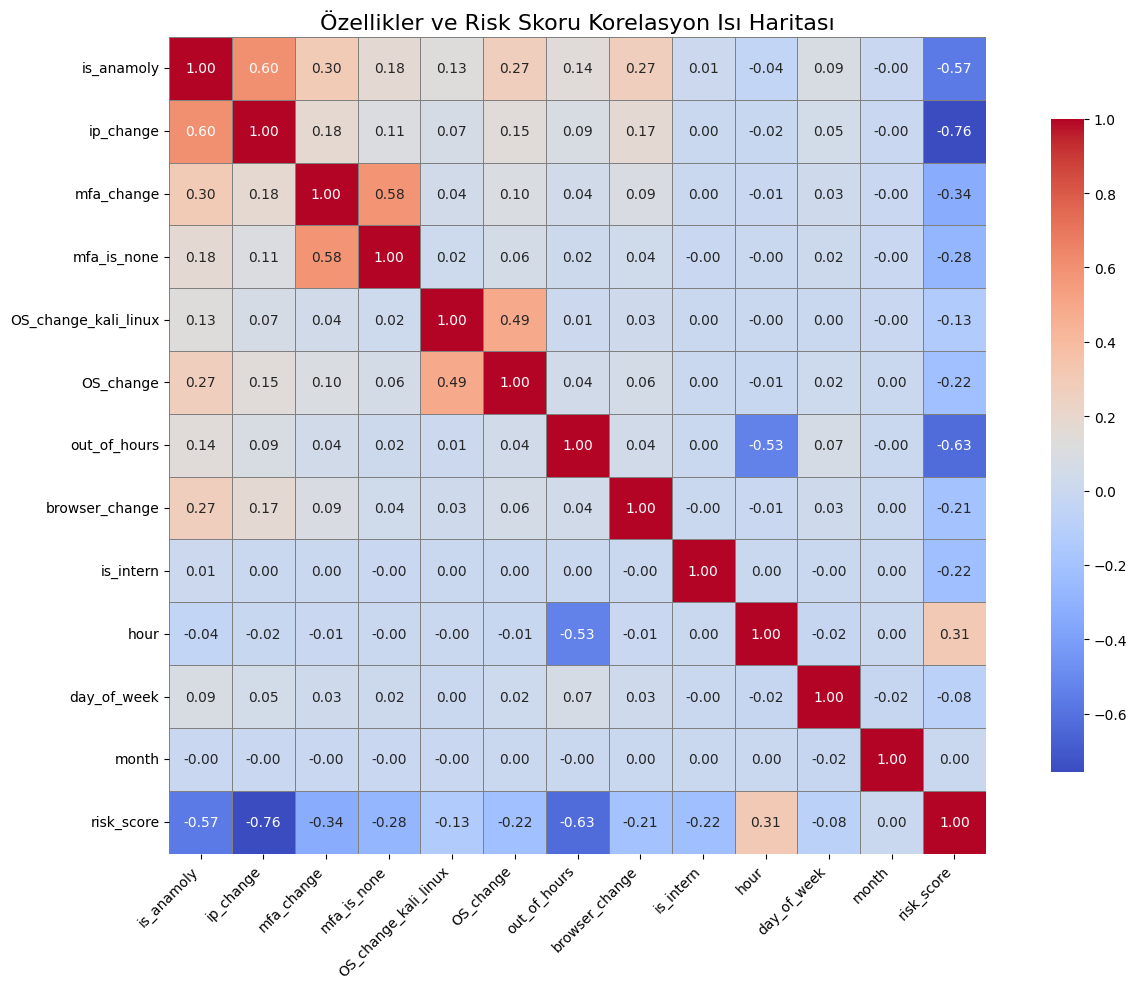

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Korelasyon matrisini hesapla
corr_matrix = lstm_df[feature_cols + ['risk_score']].corr()

# Grafik boyutu
plt.figure(figsize=(14, 10))

# Isı haritasını çiz
sns.heatmap(
    corr_matrix,
    annot=True,              # Sayısal değerleri göster
    fmt=".2f",               # Ondalık format
    cmap="coolwarm",         # Renk paleti
    linewidths=0.5,          # Hücre çizgileri
    linecolor='gray',
    square=True,
    cbar_kws={"shrink": 0.8} # Renk barı boyutu
)

plt.title("Özellikler ve Risk Skoru Korelasyon Isı Haritası", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
